# FOOOF: Tuning & Troubleshooting

<div class="alert alert-success">
WORDS. 
</div>

<div class="alert alert-info">
WORDS, go [here](02-FOOOF.ipynb).
</div>

In [63]:
%matplotlib inline

# FOOOF imports
from fooof import FOOOF, FOOOFGroup

### Interpreting Model Fit Error

FOOOF calculates and returns both the model fit error, as the root mean-squared error (RMSE) between the full psd_fit and the original PSD, as well as the model fit, as the R^2 correspondance between the original PSD and the model fit. 

These scores can be used to assess how the model is performing, however there interpretation can be a little nuanced. FOOOF is NOT optimized to minimize fit error at all costs. To do so typically results in fitting a large number of gaussian processes, in a way that overfits noise.

FOOOF is therefore built to measure PSD slope, and regions of oscillatory processes, optimized to a fuzzy definition of only fitting oscillations where there are actually oscillations (where an expert human rater would consider there to be an oscillatory 'bump'), as is not directly yoked to optimize model fit error / R^2.

Given this, while high error / low R^2 may indicate a poor model fit, very low error / high R^2 may also indicate a PSD that is overfit, in which case the oscillation parameters from the model may include overfitting to noise and thus not accurately reflect oscillatory regions. 

We therefore recommend that, for a given dataset, initial explorations should involve checking both cases in which model fit error is particularly large, or particularly low, and use these explorations to set parameters that are suitable for running across a group. There are not universal parameters that optimize this, and so FOOOF leaves it up to the user to set parameters appropriately to not under- or over-fit for a given modality / dataset / application.

### Reducing Overfitting

FOOOF, by default, is fairly unconstrained, and so the most likely 

### Reducing Underfitting



### Tuning FOOOF Settings

With default settings, FOOOF is minimally constrained. It defaults as such since there are not universal settings that work across all different dataset modalities. Appropriate settings also vary with PSD quality (noise, or effectively, the smoothness of the PSD), and frequency ranges. 

For any given dataset, FOOOF will likely need some tuning of parameters for optimal performance. 

To do so, we suggest using a combination of the following considerations:
- A priori constraints, given your data, such as the number of oscillations you expect to extract
- Qualitative analysis, guided by examing the the plotted model fit results, as compared to input data
- Quantitative analysis, considering the model fit and error (however, see note at the bottom regarding interpreting model fit error)

Tuning FOOOF is an imperfect art, and should be done carefully, as assumptions built into the settings chosen will impact the model results. For this reason, FOOOF settings should not be changed between PSDs (across channels, trials, or subjects), if they are to be meaningfully compared. We recommend ....



### Reporting Bad Fits

Words, words, words.

In [49]:
# FOOOF includes a helper method to print out instructions for reporting bad fits / bugs back to us
#  Note you can also call this from FOOOFGroup, and from instances (ex: fm.print_report_issue())
FOOOF.print_report_issue()


                             Contact / Reporting Information for FOOOF                              

                      Please report any bugs or unexpected errors on Github.                        
                           https://github.com/voytekresearch/fooof/issues                           

     If FOOOF gives you any weird / bad fits, we would like to know, so we can make it better!      
       To help us with this, send us a FOOOF report, and a FOOOF data file, for any bad fits.       

                With a FOOOF object (fm), after fitting, run the following commands:                
                              fm.create_report('FOOOF_bad_fit_report')                              
                          fm.save('FOOOF_bad_fit_data', True, True, True)                           

      Send the generated files ('FOOOF_bad_fit_report.pdf' & 'FOOOF_bad_fit_data.json') to us.      
                       We will have a look, and provide any feedback we can.          

min_amp use, for no oscillations:

This setting can be useful for datasets in which their may be flat PSDs, since in this case the standard deviation may be very low, leading to overfitting of small bumps as oscillations.

### Tuning FOOOF

Most commonly, FOOOF will overfit, being overzealous at fitting small noisy bumps as oscillations. For a given dataset, a combination of increasing the minimum bandwidth, increasing one or both of the amplitude settings, and setting an upper limit on the possible number of oscillations can assist in making FOOOF more conservative in what it defines as an oscillation.

In [31]:
def tt(ch):
    if ch:
        return
    print('1')
    print('2')

In [36]:
fg.print_settings()


                                          FOOOF - SETTINGS                                          

                                          Fit Knee : False                                          
                                      Bandwidth Limits : None                                       
                                 Max Number of Oscillations : None                                  
                                      Minimum Amplitude : None                                      
                                     Amplitude Threshold: None                                      



In [40]:
print(fg._bg_fit_func)
print(fg._bg_bounds)
print(fg._std_limits)
print(fg._bg_bounds)

<function expo_nk_function at 0x10d3abf28>
None
None
None


In [54]:
import numpy as np

In [60]:
np.corrcoef(fm.psd, fm.psd_fit_)[0][1] ** 2

0.99345340313058117

In [30]:
fg.bandwidth_limits

In [57]:
fm = FOOOF()
fm.load()

In [13]:
fg = FOOOFGroup()
fg.load()

In [29]:
fg.get_fooof(3, True)

TypeError: 'NoneType' object is not iterable

In [61]:
to_check = []
for ind, res in enumerate(fg):
    print(res.r2 + res.error)
    #if res.error > 0.015:
        #print(ind)
        #to_check.append(fg.get_fooof(ind))

1.0149228771744678
1.0041196750743568
1.0133547763442272
1.0142474375693842
1.013424755088314
1.0127124781804384
1.0062302200805464
1.0055397487838047
1.0137332818991325
1.0128643799437165
1.0055103658389524
1.0131174049425236
1.0042494156156148
1.0039159285207981
1.0037624800358427
1.0150197374031937
1.0056470854405004
1.004103441850986
1.0125977621023243
1.0125187434224825
1.0142486685003782
1.0061225049801612
1.0057297227207584
1.0055918911478339
1.005185252471024


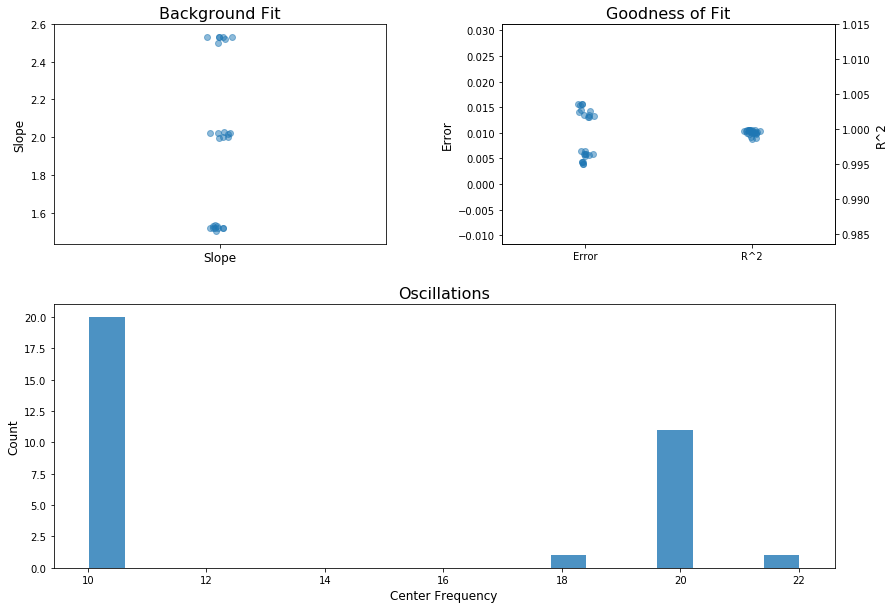

In [23]:
fg.plot()

In [18]:
for fm in to_check:
    fm.plot()
    fm.create_report()

In [19]:
to_check

[]